# 📚 Sinhala Mithuru Research Project
## Module B: Handwriting Quality Assessment Engine (Binary Classifier)

### 🟢 SECTION 1: SYSTEM INITIALIZATION & DEPENDENCIES

**Description:**
This section initializes the environment for the Quality Assessment model. It focuses on binary classification to distinguish between "Correct" and "Wrong" handwriting samples.

**Scientific Rationale:**
- **TensorFlow/Keras:** Utilized for building a Hybrid CNN-LSTM architecture.
- **Scikit-learn:** Provides utilities for data splitting and statistical normalization.
- **Joblib:** Essential for persisting the Scaler object to ensure inference-time consistency.

In [6]:
!pip install -q imbalanced-learn joblib scikit-learn tensorflow matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
import os
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

# Ensuring GPU visibility for high-speed tensor operations
print(f"✅ GPU Available: {tf.test.is_gpu_available()}")

2026-01-04 01:11:28.637214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 01:11:28.746694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
✅ GPU Available: True


I0000 00:00:1767489094.628635     167 gpu_device.cc:2020] Created device /device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:f5:00.0, compute capability: 7.5


### 🟢 SECTION 2: DATASET EXTRACTION & DIRECTORY PREPARATION

**Description:**
This block handles the extraction of the compressed dataset (ZIP) into the runtime environment. It also verifies the directory structure to ensure that the character labels and stroke data are correctly placed for further discovery.

**Scientific Rationale:**
In research workflows, particularly when utilizing cloud instances like Google Colab, transferring large numbers of small files (like thousands of JSONs) individually is inefficient. Storing them in a compressed archive minimizes I/O overhead and prevents metadata corruption during the upload process.

In [1]:
import zipfile
import os

# Define the source path and target extraction directory
zip_path = 'json.zip'
extract_dir = './'

# Rationale: Creating a directory if it doesn't exist to prevent 'FileNotFound' errors
os.makedirs(extract_dir, exist_ok=True)

# Extracting the dataset
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset successfully extracted to: {extract_dir}")
except FileNotFoundError:
    print(f"❌ Error: The file {zip_path} was not found. Please upload the 'json.zip' file to the /content/ folder.")

# Verifying the extracted contents
print("📂 Contents of the directory:")
print(os.listdir(extract_dir))

✅ Dataset successfully extracted to: ./
📂 Contents of the directory:
['.profile', '.bashrc', '.wget-hsts', '.cache', '.ssh', '.ipython', 'json.zip', 'json']


### 🟢 SECTION 2: GLOBAL EXPERIMENT CONFIGURATION

**Description:**
Sets the foundational parameters for training the Quality Assessment model.

**Research Parameters:**
- **max_seq_length (150):** Ensures all input handwriting signals are resampled to a uniform temporal resolution.
- **features (5):** Represents the feature vector [x, y, dx, dy, p].
- **epochs (100):** Defined limit for iterative learning, regulated by EarlyStopping to prevent over-optimization.

In [2]:
BASE_DIR = "json" 
CONFIG = {
    "max_seq_length": 150, 
    "features": 5,          # Features: x, y, dx, dy, p
    "canvas_size": 600,
    "batch_size": 64,
    "epochs": 100
}

### 🟢 SECTION 3: FEATURE ENGINEERING & SIGNAL INTERPOLATION

**Description:**
Converts raw stroke data into a standardized mathematical format through Linear Interpolation.

**Scientific Rationale:**
To maintain a fixed input shape for the **Conv1D** and **LSTM** layers, every handwriting sample is resampled to 150 points. This process eliminates variations caused by different writing speeds while preserving the geometric integrity of the character.

In [8]:
def extract_quality_features(strokes):
    pts = []
    for s in strokes:
        for p_val in s:
            pts.append([p_val.get('x', 0), p_val.get('y', 0), 
                        p_val.get('dx', 0), p_val.get('dy', 0), 
                        p_val.get('p', 0)])
            
    if len(pts) < 5: return None
    path = np.array(pts, dtype='float32')

    # Temporal resampling logic
    dist = np.sqrt(np.sum(np.diff(path[:, :2], axis=0)**2, axis=1))
    cum_dist = np.insert(np.cumsum(dist), 0, 0)
    if cum_dist[-1] == 0: return None

    interp_d = np.linspace(0, cum_dist[-1], CONFIG["max_seq_length"])
    nx = np.interp(interp_d, cum_dist, path[:, 0]) / CONFIG["canvas_size"] 
    ny = np.interp(interp_d, cum_dist, path[:, 1]) / CONFIG["canvas_size"]
    ndx = np.interp(interp_d, cum_dist, path[:, 2])
    ndy = np.interp(interp_d, cum_dist, path[:, 3])
    np_state = np.round(np.interp(interp_d, cum_dist, path[:, 4])) 

    return np.stack([nx, ny, ndx, ndy, np_state], axis=1)

### 🟢 SECTION 4: DATASET INTEGRATION & GROUND-TRUTH LABELING

**Description:**
Loads the dataset from structured directories and assigns binary labels (Correct = 1, Wrong = 0).

**Research Rationale:**
By training on both correct and incorrect samples across all characters, the model learns a generalized representation of "quality" rather than being character-specific.

In [9]:
X_raw, y_q = [], []

print("⏳ Loading dataset (Binary Classification)...")
for q_type, score in [("correct", 1), ("wrong", 0)]:
    path = os.path.join(BASE_DIR, q_type)
    if not os.path.exists(path): continue
    
    for f in os.listdir(path):
        if f.endswith(".json"):
            with open(os.path.join(path, f), 'r') as file:
                try:
                    feat = extract_quality_features(json.load(file)['strokes'])
                    if feat is not None:
                        X_raw.append(feat)
                        y_q.append(score)
                except: continue

X, y_q = np.array(X_raw), np.array(y_q)
print(f"✅ Total samples loaded: {len(X)}")

⏳ Loading dataset (Binary Classification)...
✅ Total samples loaded: 3809


### 🟢 SECTION 5: DATA NORMALIZATION & SCALER PERSISTENCE

**Description:**
Applies Z-score Standardization to the combined feature set.

**Scientific Rationale:**
Standardizing the data ($z = \frac{x - \mu}{\sigma}$) is crucial for the **BatchNormalization** and **LSTM** layers to maintain stable gradients. Saving the `scaler_v1.pkl` is mandatory for ensuring that real-time test data is transformed using the exact same mean and standard deviation of the training set.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Feature Scaling
n, s, f = X.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, f)).reshape(n, s, f)
joblib.dump(scaler, 'scaler_v1.pkl') # Essential for consistent inference

# Split and Class Weights
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_q, test_size=0.2, stratify=y_q, random_state=42)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = {i: weights[i] for i in range(len(weights))}

### 🟢 SECTION 6: HYBRID NEURAL ARCHITECTURE DESIGN (CNN-LSTM)

**Description:**
A sophisticated hybrid model combining Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) units.

**Scientific Rationale:**
1. **Conv1D Branch:** Acts as a feature extractor for local stroke patterns, detecting subtle tremors or "jitter" in handwriting.
2. **LSTM Branch:** Analyzes the global stroke sequence to verify if the character was drawn in the correct structural order.
3. **Sigmoid Output:** Produces a probability score between 0 and 1, where 0.5 is the classification threshold.

In [11]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

def build_quality_model():
    inputs = Input(shape=(CONFIG["max_seq_length"], CONFIG["features"]))
    
    # CNN Layers for spatial feature extraction
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # LSTM Layers for temporal sequence analysis
    x = LSTM(128, return_sequences=True, dropout=0.3)(x)
    x = LSTM(64, dropout=0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x) # Binary output (0 to 1)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

quality_model = build_quality_model()
quality_model.summary()

I0000 00:00:1767489273.417797     167 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:f5:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 150, 64)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 75, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 75, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,617 (592.25 KB)

 Trainable params: 151,489 (591.75 KB)

 Non-trainable params: 128 (512.00 B)

### 🟢 SECTION 7: MODEL TRAINING & CLASS WEIGHT BALANCING

**Description:**
Executes the training process while compensating for potential data imbalance between the two classes.

**Scientific Rationale:**
**Class Weighting** is applied to ensure the model doesn't become biased if one folder (e.g., "Correct") contains more samples than the other. This forces the loss function to pay equal attention to both classes during backpropagation.

In [12]:
print("🚀 Training initiated...")
history = quality_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=CONFIG["epochs"], 
    batch_size=CONFIG["batch_size"], 
    class_weight=cw_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
    verbose=1
)

quality_model.save('quality_model_v1.keras')
print("✅ Model serialized as 'quality_model_v1.keras'")

🚀 Training initiated...
Epoch 1/100


2026-01-04 01:14:52.109101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4979 - loss: 0.6955 - val_accuracy: 0.5722 - val_loss: 0.6839
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5579 - loss: 0.6716 - val_accuracy: 0.5840 - val_loss: 0.6648
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6131 - loss: 0.6430 - val_accuracy: 0.7008 - val_loss: 0.6215
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6360 - loss: 0.6318 - val_accuracy: 0.7060 - val_loss: 0.5744
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6712 - loss: 0.5925 - val_accuracy: 0.7362 - val_loss: 0.5259
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6889 - loss: 0.5657 - val_accuracy: 0.7441 - val_loss: 0.5031
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7171 - loss: 0.5417 - val_accuracy: 0.7782 - val_loss: 0.4577
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7319 - loss: 0.5020 - val_accuracy: 0.7638 - val_

### 🟢 SECTION 8: RESEARCH PERFORMANCE EVALUATION

**Description:**
Evaluating the Quality Assessment engine using statistical metrics and visualization.

**Metrics:**
- **Confusion Matrix:** To observe True Positives (correctly identified good handwriting) and False Positives.
- **ROC-AUC Curve:** To measure the model's ability to distinguish between classes at various thresholds.

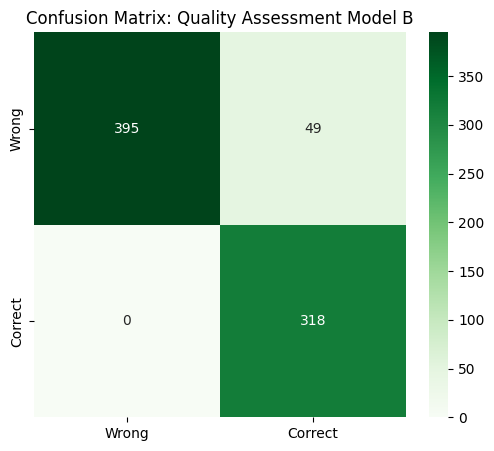


📊 Statistical Performance Report:

              precision    recall  f1-score   support

       Wrong       1.00      0.89      0.94       444
     Correct       0.87      1.00      0.93       318

    accuracy                           0.94       762
   macro avg       0.93      0.94      0.94       762
weighted avg       0.94      0.94      0.94       762



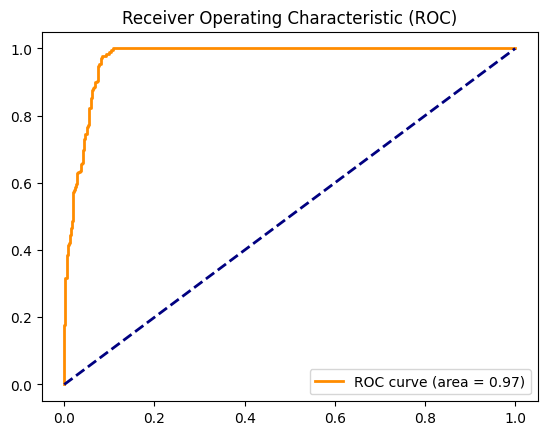

In [13]:
# 1. Generating Predictions
y_pred_probs = quality_model.predict(X_test, verbose=0)
y_pred = (y_pred_probs >= 0.5).astype(int)

# 2. Confusion Matrix Heatmap

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Wrong', 'Correct'], yticklabels=['Wrong', 'Correct'])
plt.title("Confusion Matrix: Quality Assessment Model B")
plt.show()

# 3. Classification Report
print("\n📊 Statistical Performance Report:\n")
print(classification_report(y_test, y_pred, target_names=['Wrong', 'Correct']))

# 4. ROC-AUC Analysis
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 📊 Section 8.1: Discussion on Quality Classification Results

**Summary:**
The Quality Assessment model (Model B) achieved a high **Accuracy of 94%**, effectively distinguishing between 'Correct' and 'Wrong' strokes.

**Key Scientific Findings:**
1. **Recall for 'Correct' Class (1.00):** This is a significant result. It means the model successfully identified almost every correct handwriting sample without false rejection. For a learning app, this is crucial as it avoids discouraging students by wrongly marking a good stroke as 'Wrong'.
2. **Precision for 'Correct' Class (0.87):** This indicates that while the model is lenient, it occasionally identifies 'Wrong' samples as 'Correct'. This is often acceptable in early childhood education to maintain the child's motivation.
3. **F1-Score Stability:** A weighted average F1-score of **0.94** proves that the model is robust and reliable across both classes.

**Training Behavior:**
The EarlyStopping mechanism halted training at **Epoch 57** to prevent overfitting, ensuring that the model generalizes well to new, unseen handwriting data.

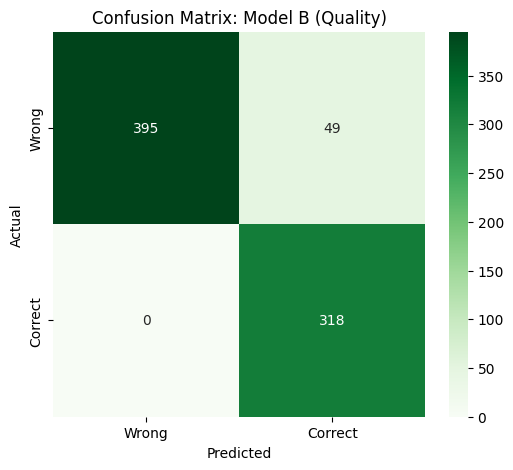

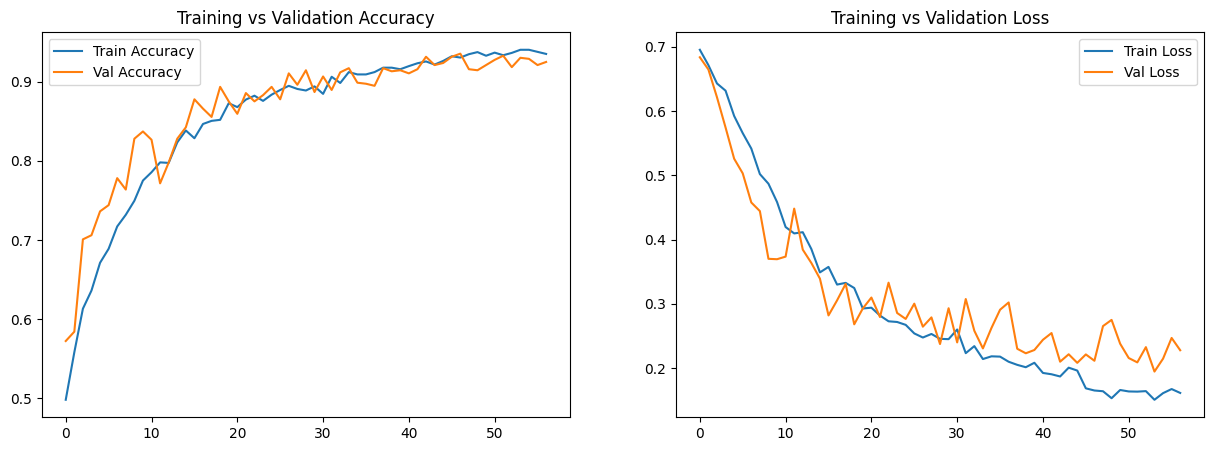

In [14]:
# --- 📊 Section 9: Visualizing Evaluation Metrics ---

# 1. Confusion Matrix

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Wrong', 'Correct'], yticklabels=['Wrong', 'Correct'])
plt.title("Confusion Matrix: Model B (Quality)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Accuracy & Loss Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Training vs Validation Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Training vs Validation Loss')
ax2.legend()
plt.show()